In [2]:
import pandas as pd
org_df=pd.read_csv('EUR_USD 과거 데이터.csv', parse_dates=['날짜'])
# 불필요한 컬럼 삭제
org_df = org_df.drop(columns=['거래량', '변동 %'], errors='ignore')
org_df = org_df.rename(columns={
    '날짜': 'Date',
    '종가': 'Close',
    '시가': 'Open',
    '고가': 'High',
    '저가': 'Low'
})

C:\Users\campus4D044\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:12:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


:막대_차트: [성능 평가]
Accuracy : 0.6794
Precision: 0.9494
Recall   : 0.3722
F1 Score : 0.5348
ROC AUC  : 0.7544

[Classification Report]
              precision    recall  f1-score   support

           0       0.61      0.98      0.76       411
           1       0.95      0.37      0.53       403

    accuracy                           0.68       814
   macro avg       0.78      0.68      0.65       814
weighted avg       0.78      0.68      0.65       814



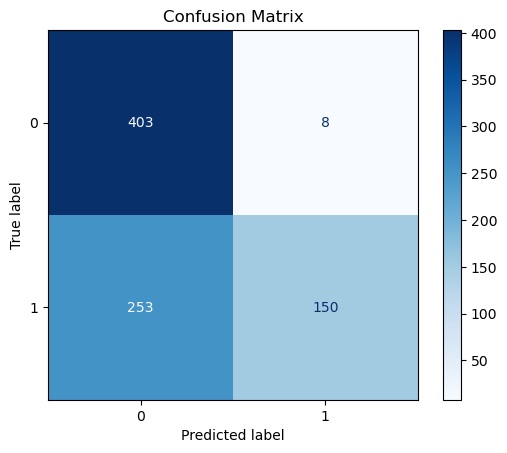

In [3]:
# -------------------------------
# 1. 라이브러리
# -------------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
# -------------------------------
# 2. 기술 지표 함수 정의
# -------------------------------
def compute_indicators(df):
    df['EMA100'] = df['Close'].ewm(span=100, adjust=False).mean()
    df['EMA150'] = df['Close'].ewm(span=150, adjust=False).mean()
    df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
    # RSI 계산
    delta = df['Close'].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    roll_up = pd.Series(gain).rolling(15).mean()
    roll_down = pd.Series(loss).rolling(15).mean()
    RS = roll_up / (roll_down + 1e-9)
    df['RSI15'] = 100.0 - (100.0 / (1.0 + RS))
    return df
# -------------------------------
# 3. 데이터 불러오기 및 처리
# -------------------------------
df = org_df.copy()
df = compute_indicators(df)
# 다음날 종가 및 상승 여부 설정
df['TargetNextClose'] = df['Close'].shift(-1)
df['TargetClass'] = (df['TargetNextClose'] > df['Close']).astype(int)
# 결측 제거
df.dropna(inplace=True)
# -------------------------------
# 4. Feature & Target 설정
# -------------------------------
features = ['Open', 'High', 'Low', 'Close', 'EMA100', 'EMA150', 'EMA20', 'RSI15']
X = df[features]
y = df['TargetClass']
# -------------------------------
# 5. 데이터 분할 (Train/Test)
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# -------------------------------
# 6. 모델 정의 (앙상블: Soft Voting)
# -------------------------------
model_lr = LogisticRegression(max_iter=1000)
model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_nb = GaussianNB()
voting_model = VotingClassifier(
    estimators=[
        ('lr', model_lr),
        ('xgb', model_xgb),
        ('gnb', model_nb)
    ],
    voting='soft'
)
# -------------------------------
# 7. 학습 및 예측
# -------------------------------
voting_model.fit(X_train, y_train)
y_pred = voting_model.predict(X_test)
y_proba = voting_model.predict_proba(X_test)[:, 1]  # ROC-AUC용
# -------------------------------
# 8. 평가 지표 출력
# -------------------------------
print(":막대_차트: [성능 평가]")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score : {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC  : {roc_auc_score(y_test, y_proba):.4f}")
print("\n[Classification Report]")
print(classification_report(y_test, y_pred))
# -------------------------------
# 9. 혼동행렬 출력
# -------------------------------
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=voting_model.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

📊 [성능 평가]
Accuracy : 0.5848
Precision: 0.9114
Recall   : 0.1787
F1 Score : 0.2988
ROC AUC  : 0.7337

[Classification Report]
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       411
           1       0.91      0.18      0.30       403

    accuracy                           0.58       814
   macro avg       0.73      0.58      0.50       814
weighted avg       0.73      0.58      0.50       814



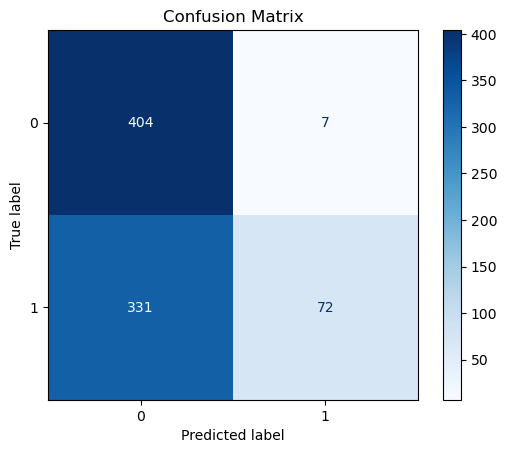

In [5]:
# -------------------------------
# 1. 라이브러리
# -------------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# -------------------------------
# 2. 기술 지표 함수 정의
# -------------------------------
def compute_indicators(df):
    df['EMA100'] = df['Close'].ewm(span=100, adjust=False).mean()
    df['EMA150'] = df['Close'].ewm(span=150, adjust=False).mean()
    df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
    # RSI 계산
    delta = df['Close'].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    roll_up = pd.Series(gain).rolling(15).mean()
    roll_down = pd.Series(loss).rolling(15).mean()
    RS = roll_up / (roll_down + 1e-9)
    df['RSI15'] = 100.0 - (100.0 / (1.0 + RS))
    return df

# -------------------------------
# 3. 데이터 불러오기 및 처리
# -------------------------------
df = org_df.copy()
df = compute_indicators(df)
df['TargetNextClose'] = df['Close'].shift(-1)
df['TargetClass'] = (df['TargetNextClose'] > df['Close']).astype(int)
df.dropna(inplace=True)

# -------------------------------
# 4. Feature & Target 설정
# -------------------------------
features = ['Open', 'High', 'Low', 'Close', 'EMA100', 'EMA150', 'EMA20', 'RSI15']
X = df[features]
y = df['TargetClass']

# -------------------------------
# 5. 데이터 분할
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

# -------------------------------
# 6. Voting Classifier 정의
# -------------------------------
model_lr = LogisticRegression(max_iter=1000, random_state=0)
model_rf = RandomForestClassifier(n_estimators=50, random_state=0)
model_nb = GaussianNB()

voting_model = VotingClassifier(
    estimators=[
        ('lr', model_lr),
        ('rf', model_rf),
        ('gnb', model_nb)
    ],
    voting='soft'
)

# -------------------------------
# 7. 학습 및 예측
# -------------------------------
voting_model.fit(X_train, y_train)
y_pred = voting_model.predict(X_test)
y_proba = voting_model.predict_proba(X_test)[:, 1]

# -------------------------------
# 8. 평가 지표 출력
# -------------------------------
print("📊 [성능 평가]")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score : {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC  : {roc_auc_score(y_test, y_proba):.4f}")
print("\n[Classification Report]")
print(classification_report(y_test, y_pred))

# -------------------------------
# 9. 혼동 행렬 출력
# -------------------------------
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=voting_model.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

📈 [Voting Classifier 성능 평가]
Accuracy : 0.6339
F1 Score : 0.4356
ROC AUC  : 0.8516

[Classification Report]
              precision    recall  f1-score   support

           0       0.58      0.98      0.73       411
           1       0.92      0.29      0.44       403

    accuracy                           0.63       814
   macro avg       0.75      0.63      0.58       814
weighted avg       0.75      0.63      0.58       814



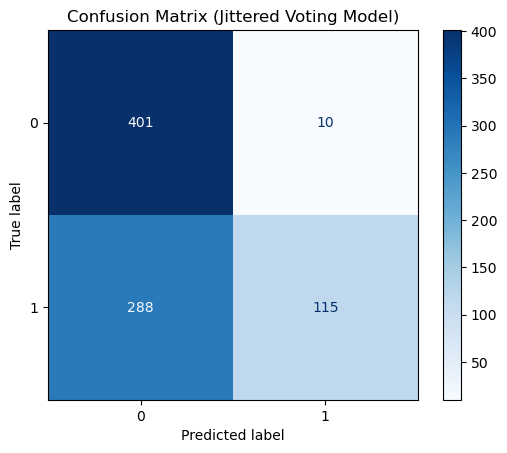

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay, f1_score
)
import matplotlib.pyplot as plt

# 기술 지표 계산 함수
def compute_technical_indicators(df):
    df = df.copy()
    df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['EMA100'] = df['Close'].ewm(span=100, adjust=False).mean()
    df['EMA150'] = df['Close'].ewm(span=150, adjust=False).mean()
    
    delta = df['Close'].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    roll_up = pd.Series(gain).rolling(14).mean()
    roll_down = pd.Series(loss).rolling(14).mean()
    RS = roll_up / (roll_down + 1e-9)
    df['RSI'] = 100.0 - (100.0 / (1.0 + RS))
    
    return df

# Jittering 함수
def jitter_data(X, y, noise_level=0.01, num_copies=1):
    jittered_X = []
    jittered_y = []
    for _ in range(num_copies):
        noise = np.random.normal(loc=0.0, scale=noise_level, size=X.shape)
        X_jittered = X + noise
        jittered_X.append(X_jittered)
        jittered_y.append(y)
    return np.vstack([X] + jittered_X), np.hstack([y] + jittered_y)

# -------------------------------
# 데이터 준비
# -------------------------------
df = org_df.copy()  # org_df는 사용자가 제공한 원본 데이터프레임
df = compute_technical_indicators(df)
df['TargetNextClose'] = df['Close'].shift(-1)
df['TargetClass'] = (df['TargetNextClose'] > df['Close']).astype(int)
df.dropna(inplace=True)

# 피처 설정
features = ['Open', 'High', 'Low', 'Close', 'EMA20', 'EMA100', 'EMA150', 'RSI']
X = df[features].values
y = df['TargetClass'].values

# -------------------------------
# Train/Test 분할 (시간순 유지)
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# -------------------------------
# Jittering 적용 (Train만!)
# -------------------------------
X_train_aug, y_train_aug = jitter_data(X_train, y_train, noise_level=0.005, num_copies=3)

# -------------------------------
# Scaling (전체에 대해)
# -------------------------------
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_aug)
X_test_scaled = scaler.transform(X_test)

# -------------------------------
# Voting Classifier 정의
# -------------------------------
model_lr = LogisticRegression(max_iter=1000, random_state=0, class_weight='balanced')
model_rf = RandomForestClassifier(n_estimators=50, random_state=0, class_weight='balanced')
model_gnb = GaussianNB()

voting_clf = VotingClassifier(
    estimators=[('lr', model_lr), ('rf', model_rf), ('gnb', model_gnb)],
    voting='soft'
)

# -------------------------------
# 학습 및 예측
# -------------------------------
voting_clf.fit(X_train_scaled, y_train_aug)
y_pred = voting_clf.predict(X_test_scaled)
y_proba = voting_clf.predict_proba(X_test_scaled)[:, 1]

# -------------------------------
# 평가
# -------------------------------

print("📈 [Voting Classifier 성능 평가]")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score : {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC  : {roc_auc_score(y_test, y_proba):.4f}")
print("\n[Classification Report]")
print(classification_report(y_test, y_pred))

# 혼동 행렬
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=voting_clf.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Jittered Voting Model)")
plt.show()


📊 [성능 평가]
Accuracy : 0.5909
Precision: 0.9167
Recall   : 0.1911
F1 Score : 0.3162
ROC AUC  : 0.7285

[Classification Report]
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       411
           1       0.92      0.19      0.32       403

    accuracy                           0.59       814
   macro avg       0.74      0.59      0.51       814
weighted avg       0.73      0.59      0.51       814



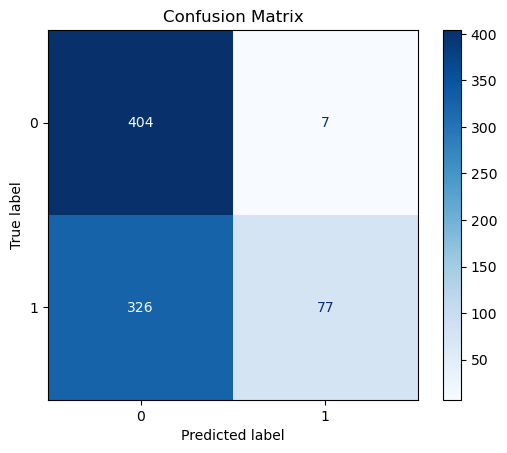

In [9]:
# -------------------------------
# 1. 라이브러리
# -------------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# -------------------------------
# 2. 기술 지표 함수 정의
# -------------------------------
def compute_indicators(df):
    df['EMA100'] = df['Close'].ewm(span=100, adjust=False).mean()
    df['EMA150'] = df['Close'].ewm(span=150, adjust=False).mean()
    df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
    # RSI 계산
    delta = df['Close'].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    roll_up = pd.Series(gain).rolling(15).mean()
    roll_down = pd.Series(loss).rolling(15).mean()
    RS = roll_up / (roll_down + 1e-9)
    df['RSI15'] = 100.0 - (100.0 / (1.0 + RS))
    return df

# -------------------------------
# 3. 데이터 불러오기 및 처리
# -------------------------------
df = org_df.copy()
df = compute_indicators(df)
df['TargetNextClose'] = df['Close'].shift(-1)
df['TargetClass'] = (df['TargetNextClose'] > df['Close']).astype(int)
df.dropna(inplace=True)

# -------------------------------
# 4. Feature & Target 설정
# -------------------------------
features = ['Open', 'High', 'Low', 'Close', 'EMA100', 'EMA150', 'EMA20', 'RSI15']
X = df[features]
y = df['TargetClass']

# -------------------------------
# 5. 데이터 분할
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

# -------------------------------
# 6. Voting Classifier 정의
# -------------------------------
model_lr = LogisticRegression(max_iter=1000, random_state=0, class_weight='balanced')
model_rf = RandomForestClassifier(n_estimators=50, random_state=0, class_weight='balanced')
model_gnb = GaussianNB()

voting_model = VotingClassifier(
    estimators=[
        ('lr', model_lr),
        ('rf', model_rf),
        ('gnb', model_nb)
    ],
    voting='soft'
)

# -------------------------------
# 7. 학습 및 예측
# -------------------------------
voting_model.fit(X_train, y_train)
y_pred = voting_model.predict(X_test)
y_proba = voting_model.predict_proba(X_test)[:, 1]

# -------------------------------
# 8. 평가 지표 출력
# -------------------------------
print("📊 [성능 평가]")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score : {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC  : {roc_auc_score(y_test, y_proba):.4f}")
print("\n[Classification Report]")
print(classification_report(y_test, y_pred))

# -------------------------------
# 9. 혼동 행렬 출력
# -------------------------------
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=voting_model.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()